In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [39]:
df = pd.read_csv("base_cleaned_data.csv")

In [40]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_num = df[num_cols].copy()

c:\Users\nnn60\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\nnn60\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\nnn60\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\nnn60\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34399 (\N{CJK UNIFIED IDEOGRAPH-865F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


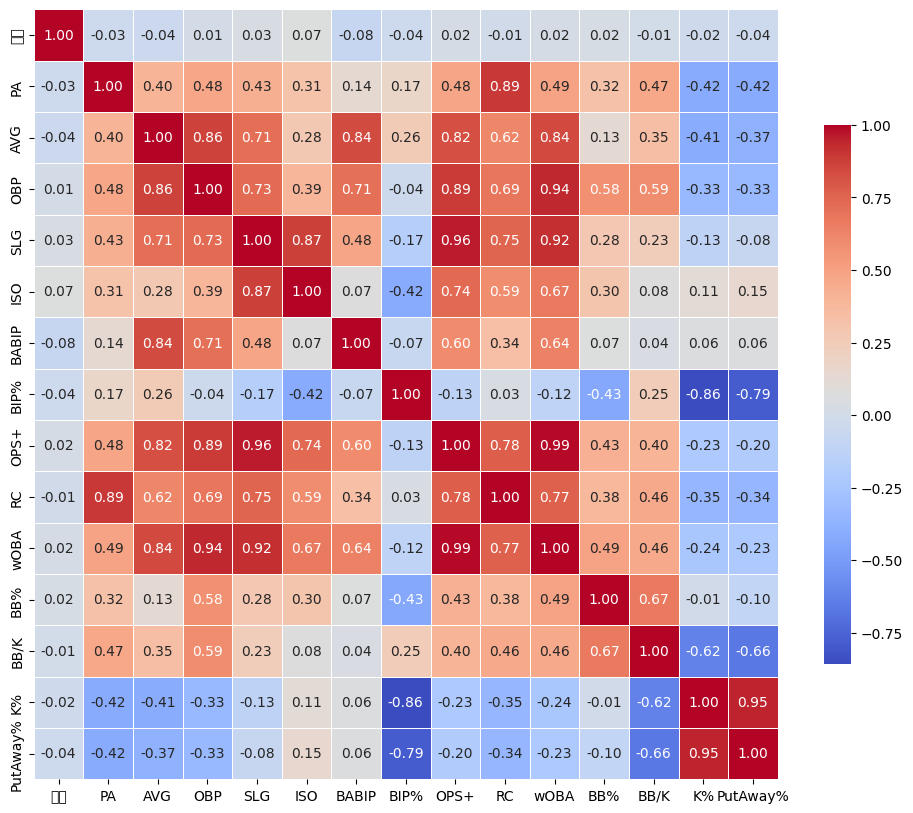

In [41]:
corr = df_num[num_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    ax=ax
)
plt.show()

In [42]:
df_model = df_num.drop(columns=['背號', 'BIP%','OBP','SLG'])

In [43]:
X = df_model.drop(columns=['OPS+'])
y = df_model['OPS+']

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=99
)

In [46]:
model = HuberRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [47]:
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
r21 = r2_score(y_test, y_pred)
k = X_test.shape[1]
n = X_test.shape[0]
adj_r21 = 1 - (1 - r21)*(n-1)/(n-k-1)
resid = y_test - y_pred
rss = np.sum(resid**2)
aic1 = n * np.log(rss/n) + 2*k
print(f"RMSE: {rmse1:.4f}")  
print(f"R^2: {r21:.4f}")
print(f"Adjusted R^2: {adj_r21:.4f}")    
print(f"AIC: {aic1:.4f}")

RMSE: 2.3547
R^2: 0.9922
Adjusted R^2: 0.9901
AIC: 102.2150


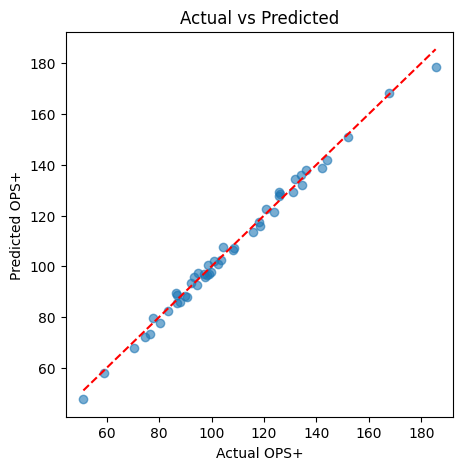

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel("Actual OPS+")
ax.set_ylabel("Predicted OPS+")
ax.set_title("Actual vs Predicted")
plt.show()

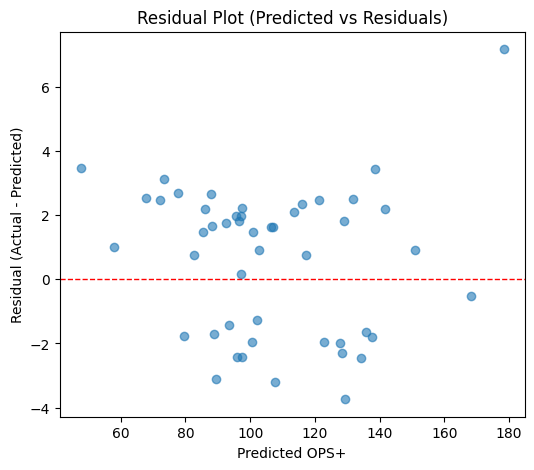

In [49]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_pred, residuals, alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)

ax.set_xlabel("Predicted OPS+")
ax.set_ylabel("Residual (Actual - Predicted)")
ax.set_title("Residual Plot (Predicted vs Residuals)")

plt.show()

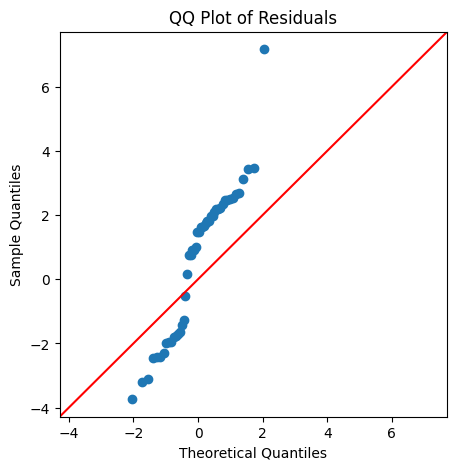

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
sm.qqplot(residuals, line='45', ax=ax)
ax.set_title("QQ Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.show()

In [67]:
model = HuberRegressor()
model.fit(X_train, y_train)

features = X.columns  # 原始欄位名稱
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


    Feature  Coefficient
4        RC    -0.242942
5      wOBA     0.240114
0        PA     0.178388
2       ISO     0.109996
1       AVG     0.090809
3     BABIP     0.021424
9  PutAway%    -0.018338
8        K%     0.013996
7      BB/K     0.003547
6       BB%     0.001504


In [69]:
pca_ratios = [0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
rmse_list = []
r2_list = []
adj_r2_list = []
aic_list = []

for ratio in pca_ratios:
    pca = PCA(n_components=ratio)
    X_pca = pca.fit_transform(X_scaled)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.3, random_state=99
    )
    
    model = HuberRegressor(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    k = X_test.shape[1]
    n = X_test.shape[0]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    resid = y_test - y_pred
    rss = np.sum(resid**2)
    aic = n * np.log(rss / n) + 2 * k
    
    rmse_list.append(rmse)
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)
    aic_list.append(aic)

    print(f"PCA {ratio*100:.0f}% -> dims: {X_pca.shape[1]}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Adj R2: {adj_r2:.4f}, AIC: {aic:.2f}")

PCA 40% -> dims: 1, RMSE: 16.6539, R2: 0.6096, Adj R2: 0.6011, AIC: 272.01
PCA 60% -> dims: 2, RMSE: 8.4796, R2: 0.8988, Adj R2: 0.8943, AIC: 209.22
PCA 80% -> dims: 3, RMSE: 8.4988, R2: 0.8983, Adj R2: 0.8914, AIC: 211.43
PCA 90% -> dims: 4, RMSE: 8.5404, R2: 0.8973, Adj R2: 0.8878, AIC: 213.90
PCA 95% -> dims: 5, RMSE: 2.6028, R2: 0.9905, Adj R2: 0.9893, AIC: 101.83
PCA 99% -> dims: 6, RMSE: 2.6530, R2: 0.9901, Adj R2: 0.9886, AIC: 105.67


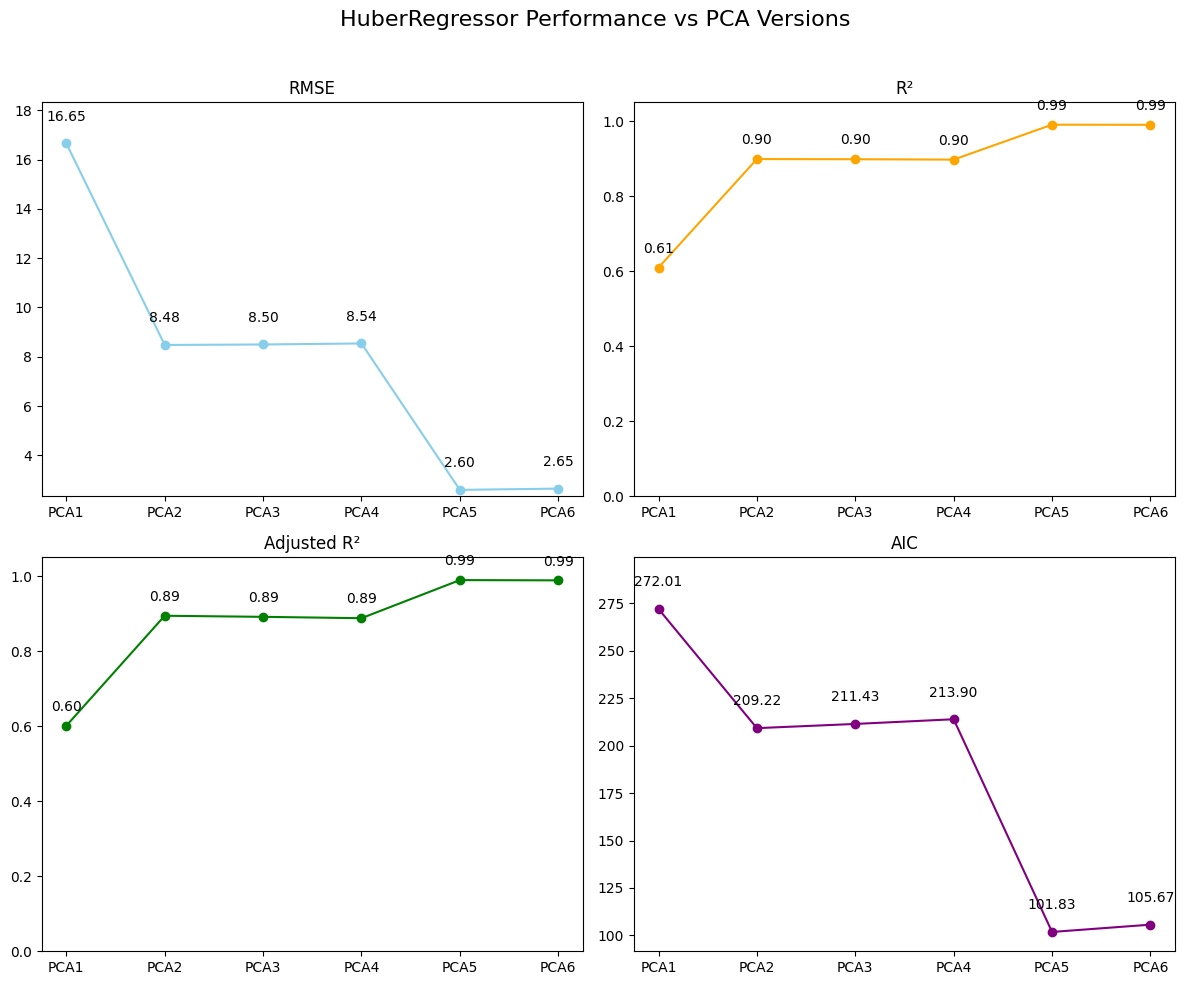

In [70]:
pca_labels = [f"PCA{i+1}" for i in range(len(pca_ratios))]

fig, axs = plt.subplots(2, 2, figsize=(12,10))
fig.suptitle('HuberRegressor Performance vs PCA Versions', fontsize=16)

ymin, ymax = min(rmse_list)*0.9, max(rmse_list)*1.1
axs[0,0].plot(pca_labels, rmse_list, marker='o', color='skyblue')
axs[0,0].set_ylim(ymin, ymax)
axs[0,0].set_title('RMSE')
for i, v in enumerate(rmse_list):
    axs[0,0].text(i, v + 0.05*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = 0, 1.05
axs[0,1].plot(pca_labels, r2_list, marker='o', color='orange')
axs[0,1].set_ylim(ymin, ymax)
axs[0,1].set_title('R²')
for i, v in enumerate(r2_list):
    axs[0,1].text(i, v + 0.03*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = 0, 1.05
axs[1,0].plot(pca_labels, adj_r2_list, marker='o', color='green')
axs[1,0].set_ylim(ymin, ymax)
axs[1,0].set_title('Adjusted R²')
for i, v in enumerate(adj_r2_list):
    axs[1,0].text(i, v + 0.03*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = min(aic_list)*0.9, max(aic_list)*1.1
axs[1,1].plot(pca_labels, aic_list, marker='o', color='purple')
axs[1,1].set_ylim(ymin, ymax)
axs[1,1].set_title('AIC')
for i, v in enumerate(aic_list):
    axs[1,1].text(i, v + 0.05*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [51]:
pca = PCA(n_components=0.95)  # 保留 95% 變異量
X_pca = pca.fit_transform(X_scaled)
print(f"原始維度: {X_scaled.shape[1]}, PCA後維度: {X_pca.shape[1]}")

原始維度: 10, PCA後維度: 5


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=99
)

In [53]:
model = HuberRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [54]:
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
r22 = r2_score(y_test, y_pred)
k = X_test.shape[1]
n = X_test.shape[0]
adj_r22 = 1 - (1 - r22) * (n - 1) / (n - k - 1)
resid = y_test - y_pred
rss = np.sum(resid**2)
aic2 = n * np.log(rss / n) + 2 * k
print(f"RMSE: {rmse2:.4f}")
print(f"R^2: {r22:.4f}")
print(f"Adjusted R^2: {adj_r22:.4f}")
print(f"AIC: {aic2:.4f}")

RMSE: 2.6028
R^2: 0.9905
Adjusted R^2: 0.9893
AIC: 101.8307


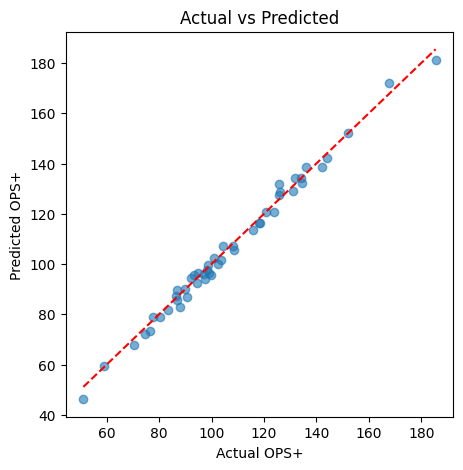

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel("Actual OPS+")
ax.set_ylabel("Predicted OPS+")
ax.set_title("Actual vs Predicted")
plt.show()

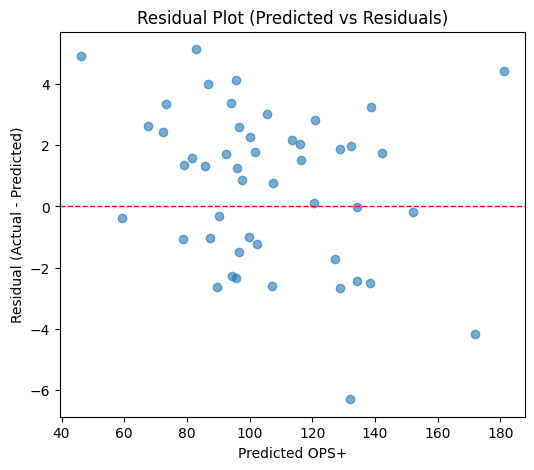

In [56]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_pred, residuals, alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)

ax.set_xlabel("Predicted OPS+")
ax.set_ylabel("Residual (Actual - Predicted)")
ax.set_title("Residual Plot (Predicted vs Residuals)")

plt.show()

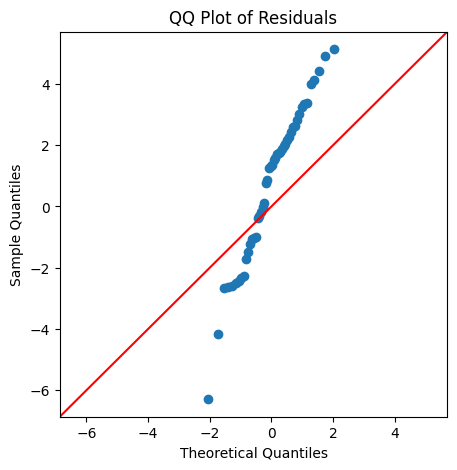

In [57]:
fig, ax = plt.subplots(figsize=(5,5))
sm.qqplot(residuals, line='45', ax=ax)
ax.set_title("QQ Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.show()

In [58]:
y_log = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log, test_size=0.3, random_state=99
)
model = HuberRegressor()
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)

resid_log = y_test - y_pred_log
sigma2 = np.var(resid_log, ddof=1)

y_pred = np.expm1(y_pred_log + 0.5*sigma2)
y_test_orig = np.expm1(y_test)

In [59]:
rmse3 = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r23 = r2_score(y_test_orig, y_pred)
k = X_test.shape[1]
n = X_test.shape[0]
adj_r23 = 1 - (1 - r23) * (n - 1) / (n - k - 1)

resid = y_test_orig - y_pred
rss = np.sum(resid**2)
aic3 = n * np.log(rss / n) + 2 * k

print(f"RMSE: {rmse3:.4f}")
print(f"R^2: {r23:.4f}")
print(f"Adjusted R^2: {adj_r23:.4f}")
print(f"AIC: {aic3:.4f}")

RMSE: 5.0438
R^2: 0.9642
Adjusted R^2: 0.9545
AIC: 175.3424


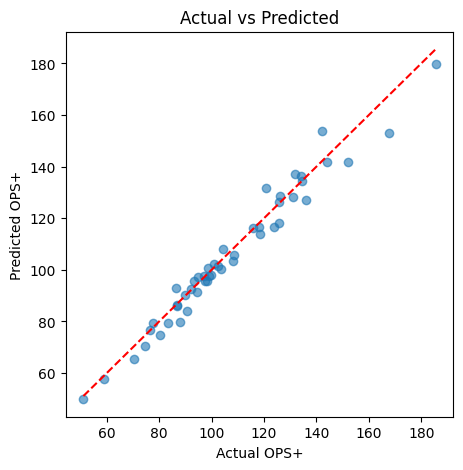

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test_orig, y_pred, alpha=0.6)
ax.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
ax.set_xlabel("Actual OPS+")
ax.set_ylabel("Predicted OPS+")
ax.set_title("Actual vs Predicted")
plt.show()

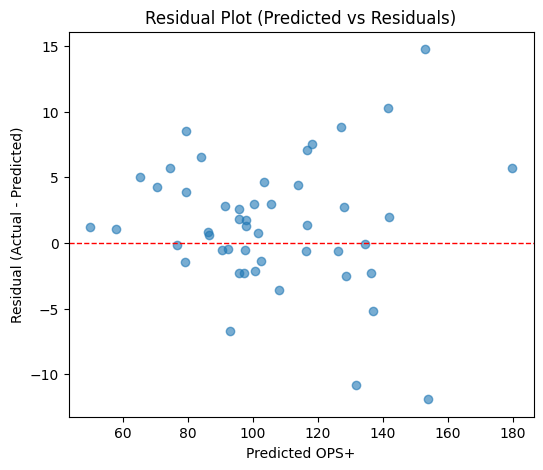

In [61]:
residuals = y_test_orig - y_pred

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_pred, residuals, alpha=0.6)
ax.axhline(0, color='red', linestyle='--', linewidth=1)

ax.set_xlabel("Predicted OPS+")
ax.set_ylabel("Residual (Actual - Predicted)")
ax.set_title("Residual Plot (Predicted vs Residuals)")

plt.show()

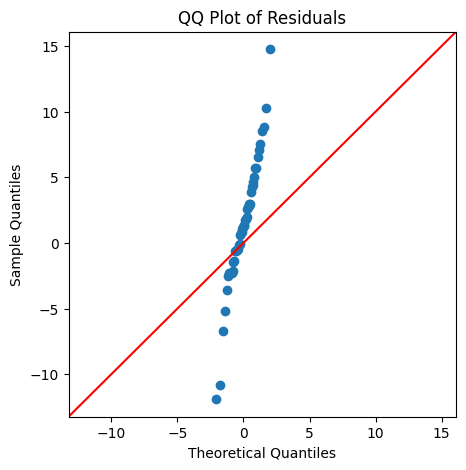

In [62]:
fig, ax = plt.subplots(figsize=(5,5))
sm.qqplot(residuals, line='45', ax=ax)
ax.set_title("QQ Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.show()

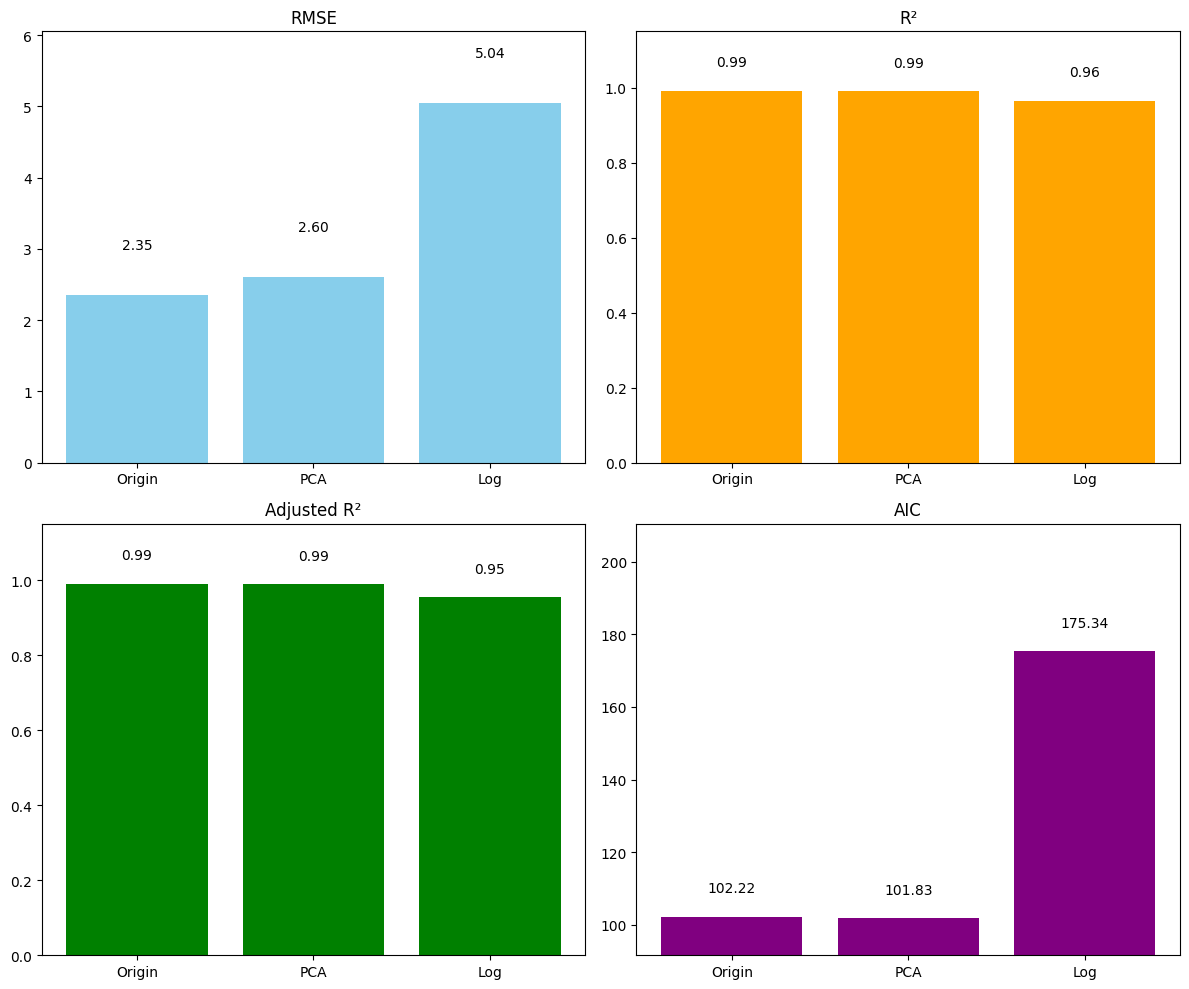

In [66]:
import matplotlib.pyplot as plt
import numpy as np

model_labels = ['Origin', 'PCA', 'Log']

rmse = [rmse1, rmse2, rmse3]
r2 = [r21, r22, r23]
adj_r2 = [adj_r21, adj_r22, adj_r23]
aic = [aic1, aic2, aic3]

fig, axs = plt.subplots(2, 2, figsize=(12,10))

ymin, ymax = 0, max(rmse)*1.20  
axs[0,0].bar(model_labels, rmse, color='skyblue')
axs[0,0].set_ylim(ymin, ymax)
axs[0,0].set_title('RMSE')
for i, v in enumerate(rmse):
    axs[0,0].text(i, v + 0.1*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = 0, 1.15  
axs[0,1].bar(model_labels, r2, color='orange')
axs[0,1].set_ylim(ymin, ymax)
axs[0,1].set_title('R²')
for i, v in enumerate(r2):
    axs[0,1].text(i, v + 0.05*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = 0, 1.15
axs[1,0].bar(model_labels, adj_r2, color='green')
axs[1,0].set_ylim(ymin, ymax)
axs[1,0].set_title('Adjusted R²')
for i, v in enumerate(adj_r2):
    axs[1,0].text(i, v + 0.05*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

ymin, ymax = min(aic)*0.9, max(aic)*1.2 
axs[1,1].bar(model_labels, aic, color='purple')
axs[1,1].set_ylim(ymin, ymax)
axs[1,1].set_title('AIC')
for i, v in enumerate(aic):
    axs[1,1].text(i, v + 0.05*(ymax-ymin), f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
